In [1]:
%matplotlib inline
import os
import copy
import textwrap

import cv2
import torch
import matplotlib.pyplot as plt
from IPython.display import display

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures.image_list import ImageList

torch.set_grad_enabled(True)
setup_logger();

In [2]:
cfg = get_cfg()
cfg.merge_from_file(os.path.expanduser("~/detectron2/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl"
predictor = DefaultPredictor(cfg)

for p in predictor.model.parameters():
    p.requires_grad_(False)

WARNING [12/09 16:58:56 d2.config.compat]: Config '/home/federico/detectron2/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [3]:
# OpenCV format: (H, W, C), where C represents BGR
original_image = cv2.imread("./marvin-meyer-SYTO3xs06fU-unsplash.jpg")
resized_image = predictor.transform_gen.get_transform(original_image).apply_image(original_image)
print(original_image.shape, '->', resized_image.shape)

(4000, 6000, 3) -> (800, 1200, 3)


In [4]:
input_image = torch.as_tensor(resized_image.astype("float32").transpose(2, 0, 1))
input_image.requires_grad_()

batched_inputs = [{"image": input_image}]
processed_images = predictor.model.preprocess_image(batched_inputs)

fpn_features = predictor.model.backbone(processed_images.tensor)
proposals, _ = predictor.model.proposal_generator(processed_images, fpn_features)
detection_results, _ = predictor.model.roi_heads(processed_images, fpn_features, proposals)
detection_results = detection_results[0]

# Detach boxes?
detection_results.pred_boxes.tensor.detach_()

box_features = predictor.model.roi_heads.box_pooler(
    [fpn_features[k] for k in ['p2', 'p3', 'p4', 'p5']],
    [detection_results.pred_boxes]
)

del batched_inputs, processed_images, fpn_features, proposals

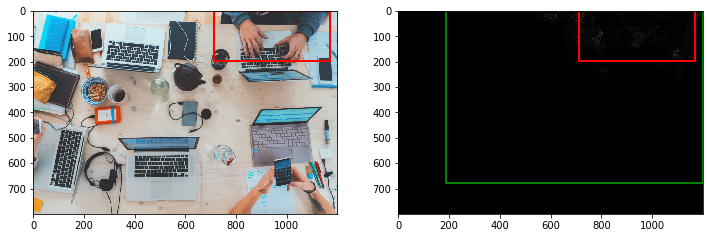

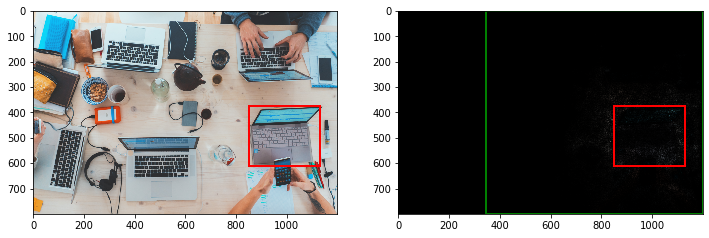

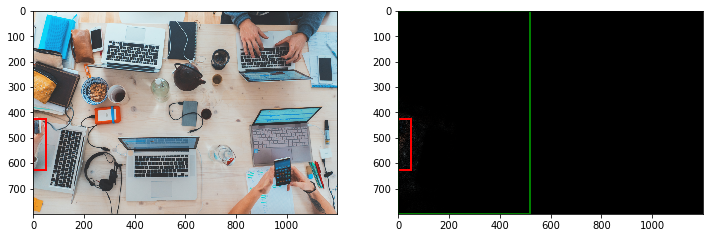

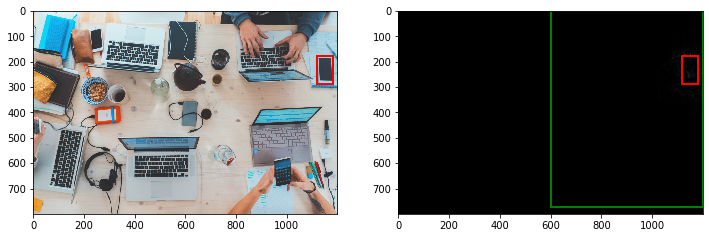

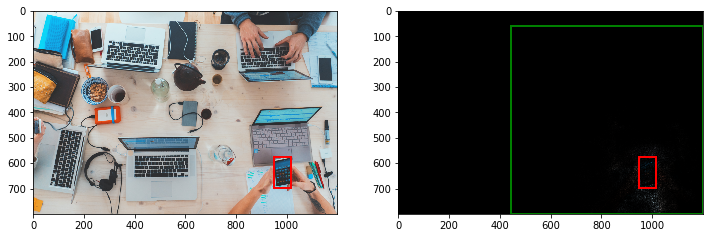

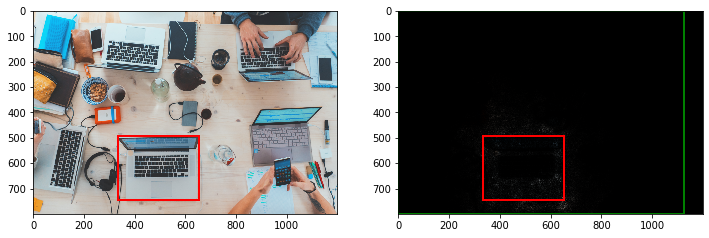

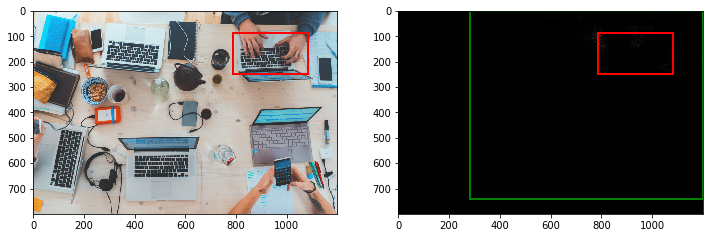

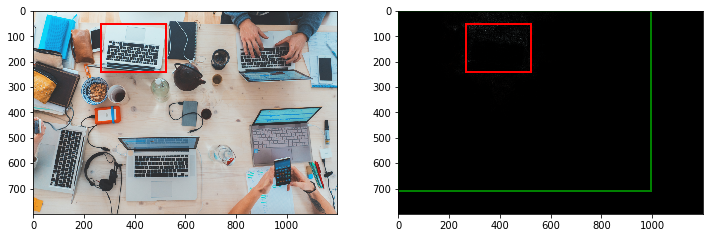

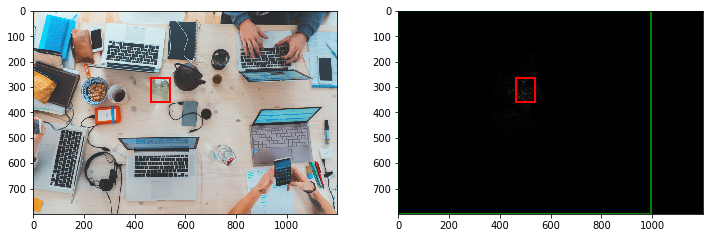

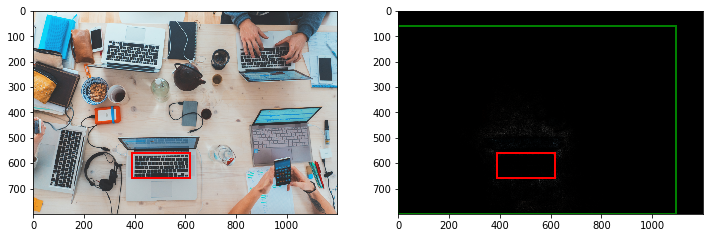

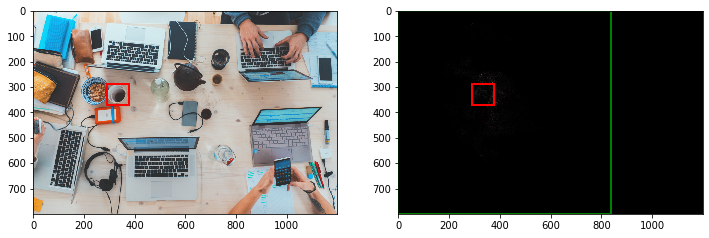

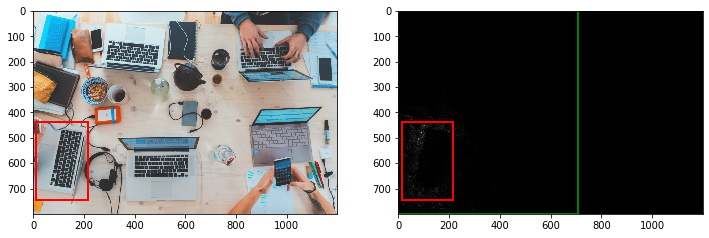

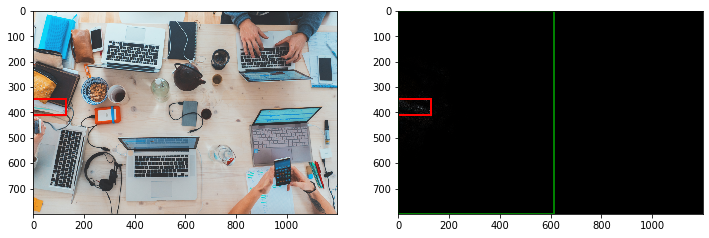

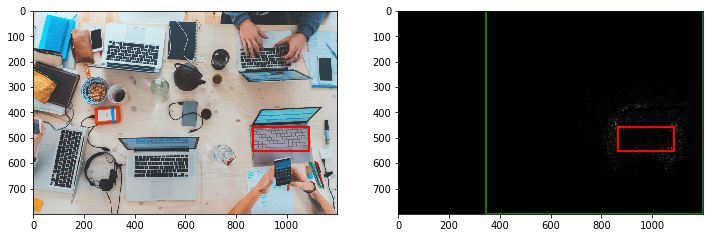

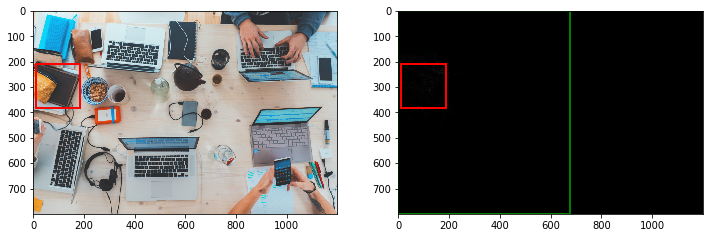

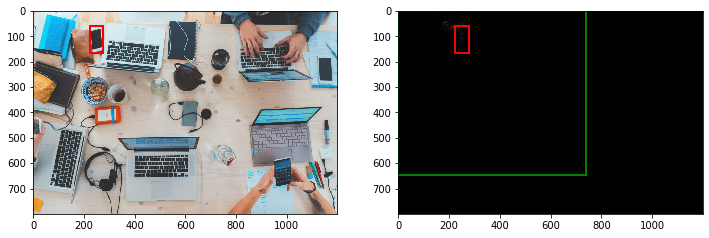

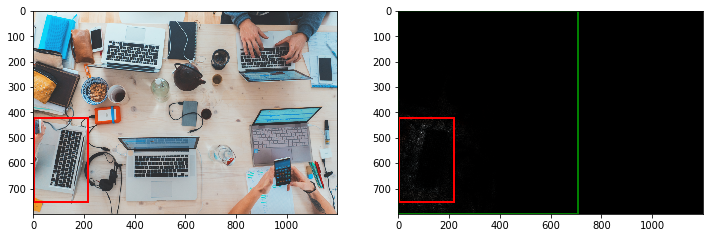

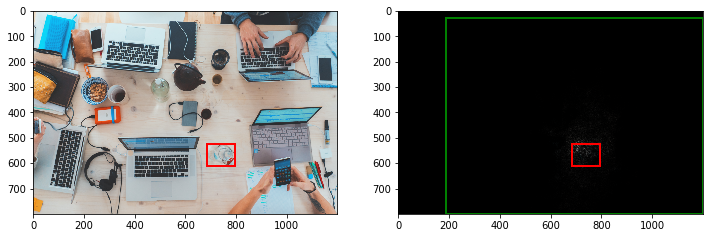

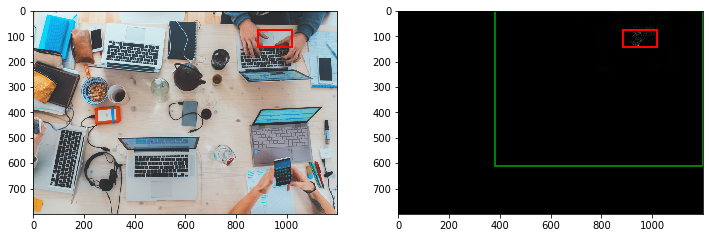

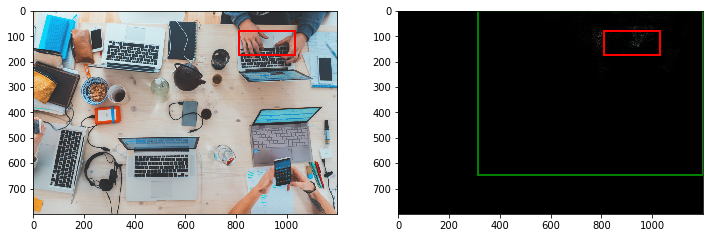

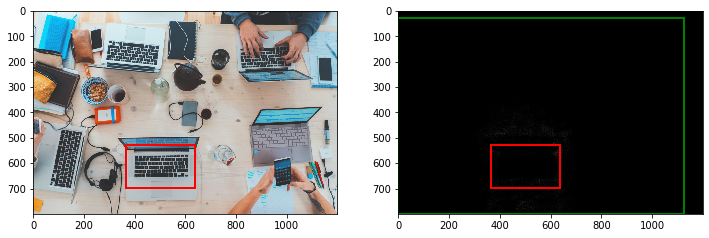

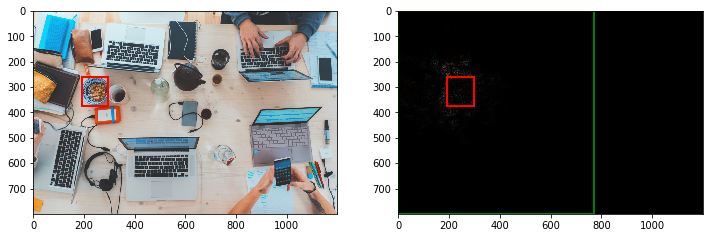

In [6]:
for box_idx in range(len(box_features)):
    input_image.grad = None
    box_features[box_idx].mean().backward(retain_graph=True)
    img_grad = input_image.grad.norm(dim=0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 4))

    ax = axes[0]
    ax.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    x0,y0,x1,y1 = detection_results.pred_boxes.tensor[box_idx].cpu().numpy()
    ax.add_patch(plt.Rectangle(
        (x0, y0), 
        width=x1 - x0, 
        height=y1 - y0, 
        fill=False,
        linewidth=2,
        color='red'
    ))

    ax = axes[1]
    ax.imshow(
        cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB) / 256. *
        ((img_grad - img_grad.min()) / (img_grad.max() - img_grad.min()))[:,:,None]
    )
    ax.add_patch(plt.Rectangle(
        (x0, y0), 
        width=x1 - x0, 
        height=y1 - y0, 
        fill=False,
        linewidth=2,
        color='red'
    ))
    (gy0, gy1), (gx0, gx1) = [(v.min(), v.max()) for v in img_grad.nonzero()]
    ax.add_patch(plt.Rectangle(
        (gx0, gy0), 
        width=gx1 - gx0, 
        height=gy1 - gy0, 
        fill=False,
        linewidth=2,
        color='green'
    ))
    
    fig.set_facecolor('white')
    display(fig)
    plt.close(fig)

del detection_results